In [45]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load the data
df_test = pd.read_excel('../translation/test_with_predictions.xlsx')
df_master = pd.read_csv('../master_model/master_model.csv')

In [46]:

df_test['pattern'] = df_test['thing'].str.replace(r'\d', '#', regex=True) + "@" + df_test['property'].str.replace(r'\d', '#', regex=True)
df_master['master_pattern'] = df_master['thing'] + "@" + df_master['property']

# Create a set of unique patterns from master for fast lookup
master_patterns = set(df_master['master_pattern'])

# Check each pattern in df_test if it exists in df_master and assign the "MDM" field
df_test['MDM'] = df_test['pattern'].apply(lambda x: "TRUE" if x in master_patterns else "FALSE")

# Display the updated DataFrame to verify the new 'MDM' field
print(df_test.head())


   Unnamed: 0                  thing   property  ships_idx  \
0           0  ISS.AMS.DataGroup01.T  _ISS-AO-1       1026   
1           1  ISS.AMS.DataGroup01.T  _ISS-AO-2       1026   
2           2  ISS.AMS.DataGroup01.T  _ISS-AO-3       1026   
3           3  ISS.AMS.DataGroup01.T  _ISS-AO-4       1026   
4           4  ISS.AMS.DataGroup01.T  _ISS-AO-5       1026   

               tag_name  equip_type_code  \
0  MB.YO.IAS.Q1.A400001              NaN   
1  MB.YO.IAS.Q1.A400002              NaN   
2  MB.YO.IAS.Q1.A400003              NaN   
3  MB.YO.IAS.Q1.A400004              NaN   
4  MB.YO.IAS.Q1.A400005              NaN   

                                     tag_description  tx_period  tx_type  \
0  NO.1 AUX. BOILER F.O PRESS IND(PIALL/PIAL/PIAH...         60        1   
1  NO.2 AUX BOILER F.O PRESS IND(PIALL/PIAL/PIAH/...         60        1   
2      NO.1 AUX.BOILER F.O TEMP INDICATION(TAH/TAHH)         60        1   
3      NO.2 AUX BOILER F.O TEMP INDICATION(TAH/TAHH)      

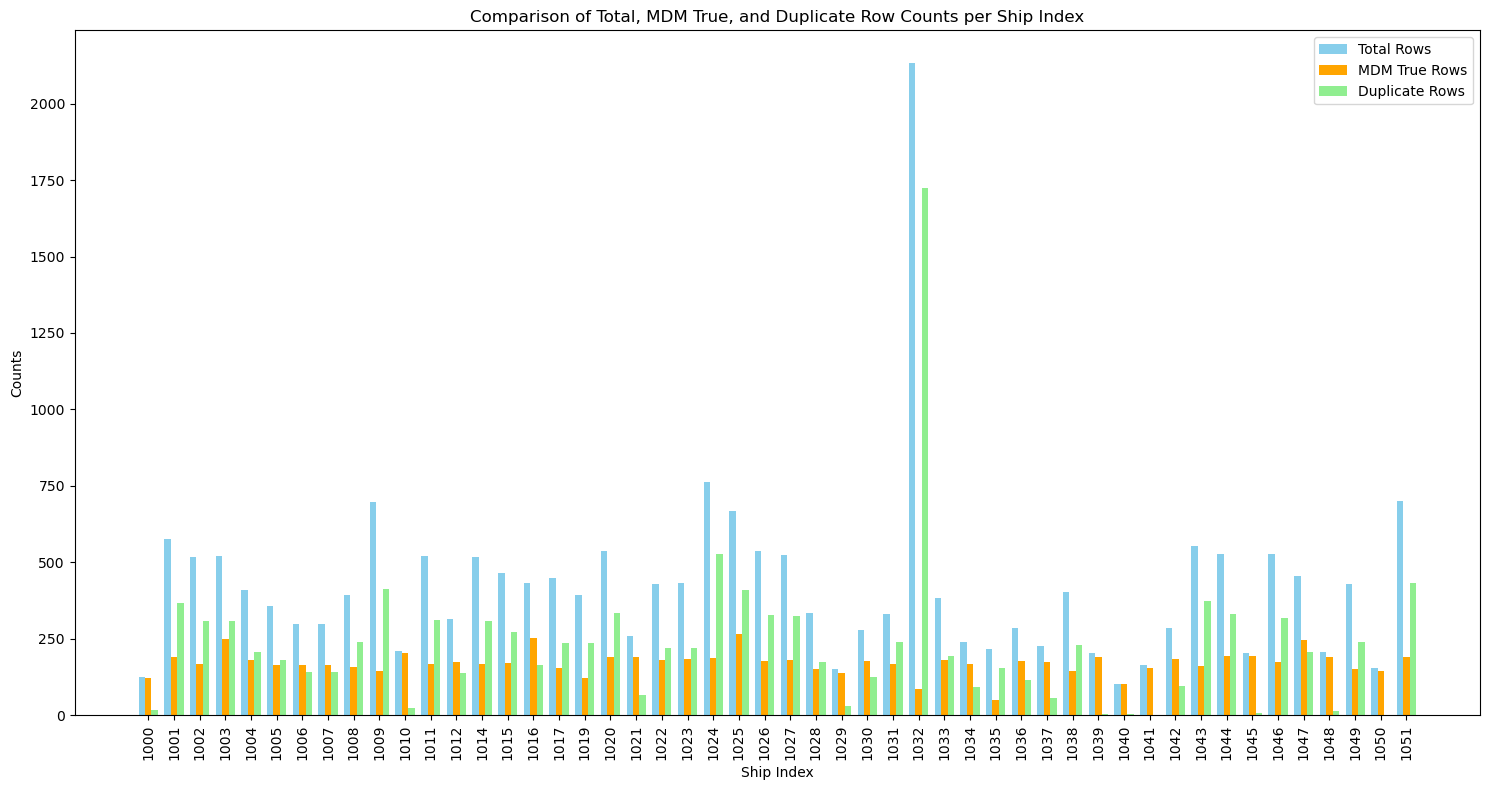

In [58]:
# Count the number of rows for each ships_idx
ship_rows_counts = df_test.groupby('ships_idx').size()

# Filter the DataFrame where 'MDM' is "TRUE" (as a string) and then count the rows for each ships_idx
ship_mdm_counts = df_test[df_test['MDM'] == "TRUE"].groupby('ships_idx').size()

# Find duplicated rows based on 'p_thing' and 'p_property' within each 'ships_idx'
df_test['is_duplicate'] = df_test.duplicated(subset=['ships_idx', 'p_thing', 'p_property'], keep=False)

# Count the number of true duplicates for each ships_idx
duplicate_counts = df_test[df_test['is_duplicate']].groupby('ships_idx').size()


# Create the figure and axis
plt.figure(figsize=(15, 8))

# Define the width of the bars and calculate positions for each group
width = 0.25  # the width of the bars
n = len(ship_rows_counts)  # the number of different ship_idx entries
r1 = range(n)  # positions for the first set of bars
r2 = [x + width for x in r1]  # positions for the second set of bars
r3 = [x + width for x in r2]  # positions for the third set of bars

# Ensure the indices are aligned
indices = list(ship_rows_counts.index.union(ship_mdm_counts.index).union(duplicate_counts.index))
ship_rows_counts = ship_rows_counts.reindex(indices, fill_value=0)
ship_mdm_counts = ship_mdm_counts.reindex(indices, fill_value=0)
duplicate_counts = duplicate_counts.reindex(indices, fill_value=0)

# Plot the bars
plt.bar(r1, ship_rows_counts, width=width, label='Total Rows', color='skyblue')
plt.bar(r2, ship_mdm_counts, width=width, label='MDM True Rows', color='orange')
plt.bar(r3, duplicate_counts, width=width, label='Duplicate Rows', color='lightgreen')

# Add some useful information to the plot
plt.xlabel('Ship Index')
plt.ylabel('Counts')
plt.title('Comparison of Total, MDM True, and Duplicate Row Counts per Ship Index')
plt.xticks([r + width for r in range(n)], indices, rotation=90)

# Create legend & Show plot
plt.legend()
plt.tight_layout()
plt.show()

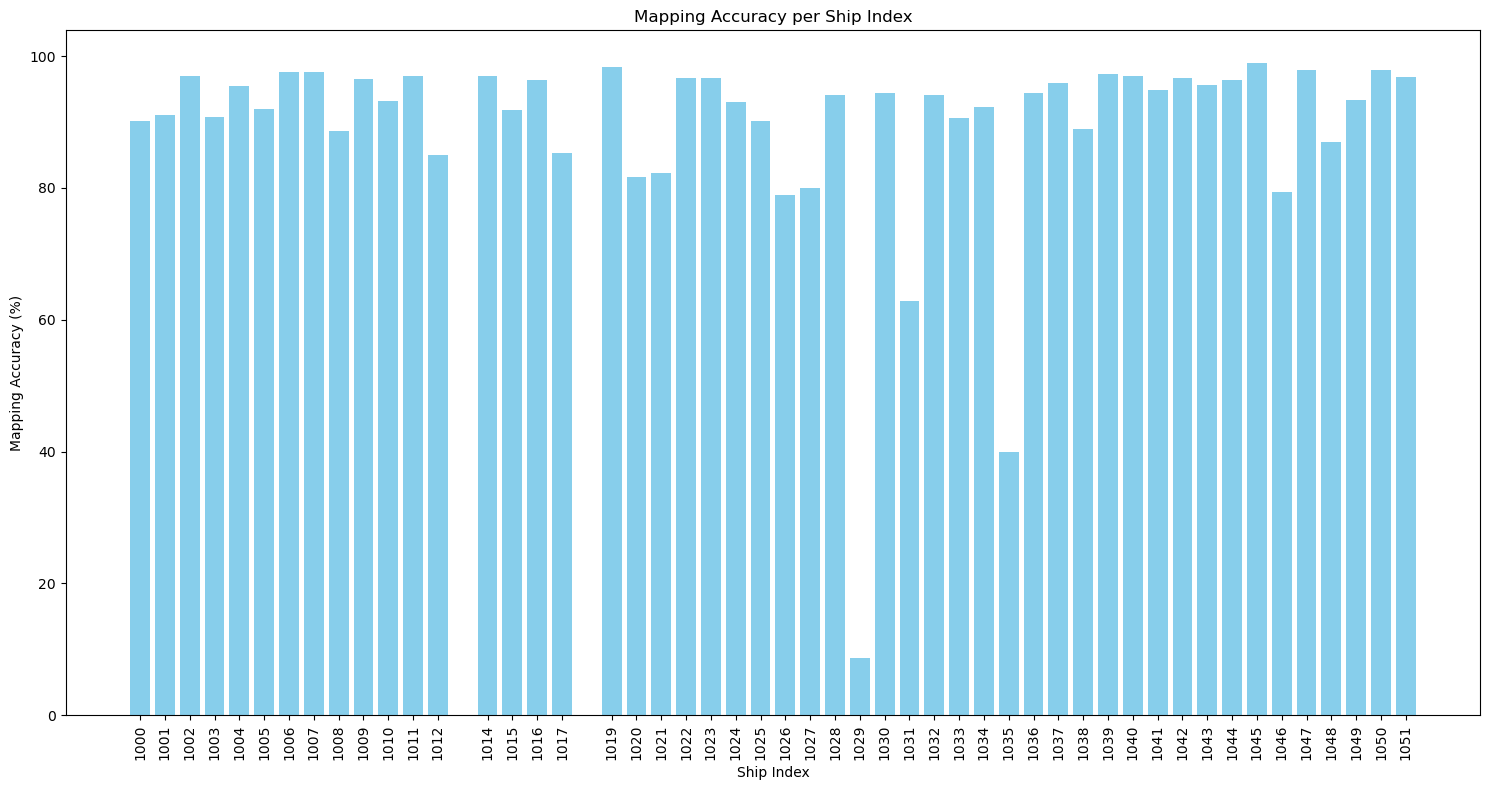

In [55]:
# Filter the DataFrame where both 'p_thing_correct' and 'p_property_correct' are "TRUE", 
# then group by 'ships_idx' and count the occurrences
correct_mappings = df_test[
    (df_test['p_thing_correct'] == True) &
    (df_test['p_property_correct'] == True) &
    (df_test['MDM'] == "TRUE")
].groupby('ships_idx').size()

# Combine the three Series into a DataFrame with appropriate column names
result = pd.concat([ship_rows_counts, ship_mdm_counts, correct_mappings], axis=1)
result.columns = ['ship_rows_counts', 'ship_mdm_counts', 'correct_mappings']

# Reset index to turn the index into a regular column if necessary
result = result.reset_index()

# Fill NaN values with 0 where there are no mappings or mdm counts
result['ship_mdm_counts'] = result['ship_mdm_counts'].fillna(0)
result['correct_mappings'] = result['correct_mappings'].fillna(0)

# Calculate mapping accuracy and handle division by zero by replacing infinity with NaN or zero
result['mapping_accuracy'] = result['correct_mappings'] / result['ship_mdm_counts'].replace({0: pd.NA})

# Replace infinite values with NaN if there were division by zero cases
result['mapping_accuracy'] = result['mapping_accuracy'].fillna(0)

# Convert to percentage if desired
result['mapping_accuracy'] *= 100

plt.figure(figsize=(15, 8))  # Adjust the size as needed
plt.bar(result['ships_idx'], result['mapping_accuracy'], color='skyblue')

plt.title('Mapping Accuracy per Ship Index')
plt.xlabel('Ship Index')
plt.ylabel('Mapping Accuracy (%)')

# Rotate x-axis labels to prevent overlap
plt.xticks(result['ships_idx'], rotation=90)

plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()